In [112]:
import G_utils.p_matrix as p_matrix
from G_utils.spectral_clustering import spec_clustering 
from itertools import combinations,permutations
from  scipy.stats import lognorm
from numpy.random import default_rng

import matplotlib.pyplot as plt
import GERDA_light as gl
import numpy as np
import joblib as jb
import logging as log
import time
import copy 
logger = log.getLogger()
logger.setLevel(log.INFO)

from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)
#plt.style.use('dark_background')
plt.style.use('seaborn-v0_8-colorblind')

In [65]:

class Agent(object):
    def __init__(self,ID, state, size):
        self.ID = ID
        self.state = state
        self.times = {'infection': None}
        self.size = size
 

class World(object):
    def __init__(self, p_l_t_filepath = 'source/Gangelt_03_new_p_l_t.gz',
                       ai_df_filename = 'source/Gangelt_03_new_ai_df.gz',
                       clustering = True,
                       k_I: float = 0.2 ,
                       infection_times_cluster_list=[0,1,2,2,3,3,3,4,4,4,5,5,5,5,5,6,6,6,6,6,7,7,7,7,8],
                       **cluster_kwargs :dict):

        self.infect_prob_dist = create_lognorm_probability_dist(s=1,a=4, days=30) ## in days
        self.infect_prob_dist_per_size = get_infection_prob_dist_dict(s=1,a=4,infection_times_cluster_list=infection_times_cluster_list)
        self.global_inf = k_I
        self.clustering = clustering
        
        if clustering:
            log.debug('world with clusters of agents')
            self.SC = spec_clustering(**cluster_kwargs,
                                      plt_filename = p_l_t_filepath,
                                      ai_df_filename = ai_df_filename,
                                      )

            self.p_l_t = self.SC.p_l_t
            self.ai_df = self.SC.ai_df
            self.hID_cID_dict = get_hID_cID_dict(self.SC)
            self.agent_contacts = p_matrix.contact_lists_from_p_l_t(self.p_l_t, directed=False)
            self.contacts = agent_contacts_to_cluster_contacts(self.agent_contacts,self.hID_cID_dict)
            self.generate_agents(column = 'cluster')
        
        else:
            self.p_l_t = jb.load(p_l_t_filepath)
            self.ai_df = jb.load(ai_df_filename)    
            log.debug('world with agents without clustering')
            self.SC = None 
            self.contacts = p_matrix.contact_lists_from_p_l_t(self.p_l_t, directed=False)
            self.generate_agents(column = 'h_ID')

        self.n_agents = self.p_l_t.shape[0]-1 ## 0 is not an agent
        self.schedule_time_span = self.p_l_t.shape[1]
        # self.initialize_infections([1])

         
    def generate_agents(self, column = 'h_ID')->dict:
        if column== 'cluster':
            self.agents = {ID: Agent(ID, 0, size = self.ai_df['cluster_size'][self.ai_df[column]==ID].values[0]) for ID in self.ai_df[column].unique()}
        else:
            self.agents = {ID: Agent(ID, 0, size = 1) for ID in self.ai_df[column].unique()}     
       
    
    def initialize_infections(self, agents_to_infect=[1]):
        for hID in agents_to_infect:
            self.agents[hID].state=1 # infect one agent
            self.agents[hID].times['infection']=0 


def agent_contacts_to_cluster_contacts(agent_contacts,hID_cID_dict):
    cluster_contacts = {} ### dict t: [(c1,c2,p),...]
    for t, c in agent_contacts.items():
        cluster_contacts[t] = [(hID_cID_dict[x-1],hID_cID_dict[y-1],p) for x,y,p in c if hID_cID_dict[x-1] != hID_cID_dict[y-1]]  ## agent ID transfomation -1!!!!
        ## only for logging
        inner_cluster_interactions = len([1 for x,y,p in c if hID_cID_dict[x-1] == hID_cID_dict[y-1]])
        log.info(f'inner cluster interactions {inner_cluster_interactions}')
    return cluster_contacts   

def get_hID_cID_dict(SC):
    ##  human ID to cluster ID dictionary
    SC.ai_df.cluster.unique()
    SC.ai_df.set_index('h_ID')
    return SC.ai_df['cluster'].to_dict()
   

class SIS_model(object):
    def __init__(self,world,t=1):
        self.w0 = copy.deepcopy(world)
        self.world = world ##
        self.real_contacts = {}
        self.schedule_time_span = 168
        self.t = t
    
    def reset(self):
        self.__init__(self.w0,t=1)
        
    def run(self,timespan=96, 
            only_inf_rel_contacts=True,
            size_dependent_inf_prob=True):
        
        if size_dependent_inf_prob:
            log.debug(f'using cluster size dependent  infection probability:')
        for t in range(self.t, self.t +timespan+1):
            self.t
            st = self.t_to_schedule_t(t) # st schedule time or time of the week
            ## filter for infection relevant contacts only
            if only_inf_rel_contacts:
                reduced_contacts = [x for x in self.world.contacts[st] if set((self.world.agents[x[0]].state,self.world.agents[x[1]].state))=={0,1}] ## falsch!!!
                log.debug(f'{len(reduced_contacts)} infection relevant interactions out of {len(self.world.contacts[st])} total interactions')
                contact_pairs = self.determine_contact_pairs(reduced_contacts)
            else:
                contact_pairs = self.determine_contact_pairs(self.world.contacts[st])    
            self.real_contacts[t] = contact_pairs
            for pair in contact_pairs:
                self.infection_attempt(pair,t,size_dependent_inf_prob=size_dependent_inf_prob)
    
    def infection_attempt(self, pair: tuple,t:int,size_dependent_inf_prob=True):
        a1, a2 = self.world.agents[pair[0]], self.world.agents[pair[1]] 
        states = (a1.state ,a2.state)
        
        if set(states)== {0,1}:
            agents = [[a1,a2][x] for x in states] ## sorting that agent[0] has state 0 and vice versa 
            ## infection probability
            inf_duration_days = int((t-agents[1].times['infection'])/24)
            if inf_duration_days < 21:
                if size_dependent_inf_prob:
                    p_I = self.world.global_inf * self.world.infect_prob_dist_per_size[agents[1].size][inf_duration_days]
                else:    
                    p_I = self.world.global_inf * self.world.infect_prob_dist[inf_duration_days]
                if p_I > np.random.random():
                    log.debug(f'p_I: {p_I}')
                    agents[0].state = 1  ## infected without preliminary, however p_I is 0 anyways for 1-2 days
                    agents[0].times['infection'] = t
                    self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df 
    
    def determine_contact_pairs(self,contact_list: list,seed=None)->list:
        rng = default_rng(seed=seed)
        contact_pairs =[(x[0],x[1]) for x in contact_list if x[2]>rng.random(1)]
        log.debug(f'{len(contact_pairs)} contact pairs out of {len(contact_list)}')
        return contact_pairs
    
    def t_to_schedule_t(self, t:int)->int:
        return t%self.schedule_time_span
                    

### utility function
def create_lognorm_probability_dist(s:float =1, ## sigma of lognorm
                                    a:float =4.0, ## mean of lognorm
                                    days=30):
    x = np.linspace(0,days+1,days+1)
    dist=lognorm(s,loc=a)
    pdf = dist.pdf(x)
    p = pdf/pdf.sum()
    log.debug(f'max probability  at day  {np.argmax(p)}')
    return p

def get_infection_prob_dist_dict(infection_times_cluster_list: list=[0,2,2,2,2,3,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,7],
                                 s=1, ## sigma of lognorm
                                 a=4, ## mean of lognorm
                                 )-> dict:
    """creates average infection probability distribution for different cluster sizes based on given infection times.

    Args:
        infection_times_cluster_list (list, optional): ordered list of infection times inside the cluster
        Defaults to [0,2,2,2,2,3,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,7].

    Returns:
        dict: probability dist per cluster size 
    """
    max_inf_time = max(infection_times_cluster_list)
    
    if max_inf_time > 10:
        days = max_inf_time + 10
    else:
        days = 30    

    p = create_lognorm_probability_dist(s=s,a=a,days=days)
    prob_per_size_dict = {1: p}
    max_cluster_size = len(infection_times_cluster_list)
    
    for i in range(1,max_cluster_size + 1):
        ps = [np.array(int(infection_times_cluster_list[k])*[0.0]+list(p[:-(int(infection_times_cluster_list[k]))])) for k in range(1,i)]
        prob_per_size_dict[i] = sum([p] + ps)/i
    return prob_per_size_dict 

In [41]:
### create plt and ai_df  for 10 - 200 agent in one location to create infection times
def create_homogenous_world(n_agents=10, k_I=0.2):
    w  = World(p_l_t_filepath = 'src/Gangelt_03_new_p_l_t.gz',
            ai_df_filename = 'src/Gangelt_03_new_ai_df.gz',
            clustering=False,
            k_I=k_I)
    df = w.ai_df#.drop(w.ai_df[w.ai_df['h_ID']>10])
    w.ai_df = df[df['h_ID']<n_agents+1]
    w.p_l_t = np.ones(shape=(n_agents+1,168)).astype(int) ## first line is no agent ->0 
    w.p_l_t[0] = 0 * w.p_l_t[0] ## first line is no agent ->0 
    w.contacts = p_matrix.contact_lists_from_p_l_t(w.p_l_t, directed=False)
    w.generate_agents(column = 'h_ID')
    w.n_agents=w.p_l_t.shape[0]-1
    w.schedule_time_span = w.p_l_t.shape[1]
    w.initialize_infections([1])
    return w 

def average_lists(t_lists: list)->list: 
    ## required since the lists have not the same length
    max_len = max([len(lst) for lst in t_lists])
    t_array = np.full((len(t_lists), max_len), np.nan)
    for i, lst in enumerate(t_lists):
        t_array[i, :len(lst)] = lst

    mean_inf_times = np.nanmean(t_array, axis=0).astype(int)
    return mean_inf_times

def get_average_infection_times(agents=12, n=50, t= 600, k_I=0.2):
    t_lists=[]
    w = create_homogenous_world(n_agents=agents, k_I=0.2)
    for _ in range(n): ### average over n simulations 
        w_t = copy.deepcopy(w)
        model_t = SIS_model(w_t)
        model_t.run(timespan=t)
        times = [int(a.times['infection']/24) for a in model_t.world.agents.values() if a.times['infection'] is not None]
        times.sort()
        t_lists.append(times)
        del w_t

    mean_inf_times = average_lists(t_lists)
    return mean_inf_times

In [36]:
mean_inf_times = get_average_infection_times(agents=50,t=600)
print(len(mean_inf_times))


INFO:root:create contact list


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df


50


In [37]:
mean_inf_times

array([ 0,  4,  4,  5,  6,  7,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
       11, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 19, 19, 20, 20, 21])

In [38]:
for ti in range(300,1200,100):
    inf_times = get_average_infection_times(agents=50,t=ti)
    print(f't: {ti} \\ n: {len(inf_times)} , timings : {inf_times}')
## ti 800 is enough    

INFO:root:create contact list
INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df
INFO:root:create contact list


t: 300 \ n: 30 , timings : [ 0  4  5  5  6  7  8  8  8  9  9  9  9 10 10 10 10 10 10 10 10 11 10 11
 11 11 11 11 11 12]


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df
INFO:root:create contact list


t: 400 \ n: 48 , timings : [ 0  4  4  5  6  7  7  8  9  9  9  9 10 10 10 10 11 11 11 11 11 12 12 12
 12 12 12 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 16]


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df
INFO:root:create contact list


t: 500 \ n: 50 , timings : [ 0  4  4  5  6  7  8  8  9  9 10 10 10 11 11 11 11 12 12 12 12 13 13 13
 13 13 13 14 14 14 14 15 15 15 15 15 15 16 16 16 16 16 16 17 17 17 17 18
 18 19]


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df
INFO:root:create contact list


t: 600 \ n: 50 , timings : [ 0  4  4  5  6  7  8  8  9  9  9 10 10 10 10 11 11 11 12 12 12 13 13 13
 13 13 14 14 14 14 14 15 15 15 15 15 16 16 16 17 17 17 18 18 18 19 19 20
 20 21]


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df
INFO:root:create contact list


t: 700 \ n: 50 , timings : [ 0  4  4  5  6  7  8  8  9  9  9 10 10 10 10 11 11 12 12 12 12 12 13 13
 13 13 14 14 14 14 14 15 15 15 15 15 16 16 16 16 17 17 17 18 18 19 19 19
 21 22]


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df
INFO:root:create contact list


t: 800 \ n: 50 , timings : [ 0  4  4  5  7  7  8  9  9 10 10 10 10 11 11 11 12 12 12 12 13 13 13 13
 14 14 14 14 15 15 15 15 15 16 16 16 16 17 17 17 18 18 18 19 19 20 20 22
 22 23]


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df
INFO:root:create contact list


t: 900 \ n: 50 , timings : [ 0  4  4  5  6  7  8  8  9  9 10 10 10 10 11 11 11 11 12 12 12 12 13 13
 13 13 14 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17 18 18 19 19 20
 21 23]


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df
INFO:root:create contact list


t: 1000 \ n: 50 , timings : [ 0  4  4  5  6  7  7  8  9  9  9 10 10 10 11 11 11 11 12 12 12 12 13 13
 13 13 14 14 14 14 14 15 15 15 15 16 16 16 16 16 17 17 18 18 18 19 19 20
 21 23]


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df


t: 1100 \ n: 50 , timings : [ 0  4  4  5  7  7  8  9  9 10 10 10 11 11 11 12 12 12 13 13 13 13 13 14
 14 14 14 15 15 15 15 16 16 16 16 16 17 17 17 18 18 18 18 19 19 20 21 22
 23 25]


In [45]:
inf_times

array([ 0,  4,  4,  5,  7,  7,  8,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12,
       12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16,
       16, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 20, 21, 22, 23, 25])

In [43]:
import copy
## test wether larger cluster give different pattern : answer - no , so one infection time pattern is enough 
inf_time_per_clustersize_dict = {}

for i in range (2,30):
    t_lists=[]
    w = create_homogenous_world(n_agents=i)
    for _ in range(50): ### average over n simulations 
        w_t = copy.deepcopy(w)
        model_t = SIS_model(w_t)
        model_t.run(timespan=600)
        times = [int(a.times['infection']/24) for a in model_t.world.agents.values() if a.times['infection'] is not None]
        times.sort()
        t_lists.append(times)
        del w_t

    mean_inf_times = get_average_infection_times(t_lists)
    inf_time_per_clustersize_dict[i]  = mean_inf_times
inf_time_per_clustersize_dict       

INFO:root:create contact list


INFO:root:contact list is done
INFO:root:create contact list
INFO:root:contact list is done
/var/folders/gt/s6pdfdj96zj_zvbg5c6lj1nm0000gn/T/ipykernel_23724/1900669694.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.world.ai_df[self.world.ai_df['h_ID']==agents[0].ID]['infection_time'] = t ## to df
INFO:root:create contact list
INFO:root:contact list is done


TypeError: can only concatenate list (not "int") to list

[0, 4]

In [394]:
model_test = SIS_model(w3)
model_test.world.agents[3].state=1 # infect one agent
model_test.world.agents[3].times['infection']=0 
model_test.world.contacts
model_test.run(timespan=1000)
#[x for x in model_test.world.contacts[1] if set((model_test.world.agents[x[0]].state,model_test.world.agents[x[1]].state))=={0,1}]
set((model_test.world.agents[2].state,model_test.world.agents[3].state))

INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 45 total interactions
INFO:root:9 infection relevant interactions out of 

{1}

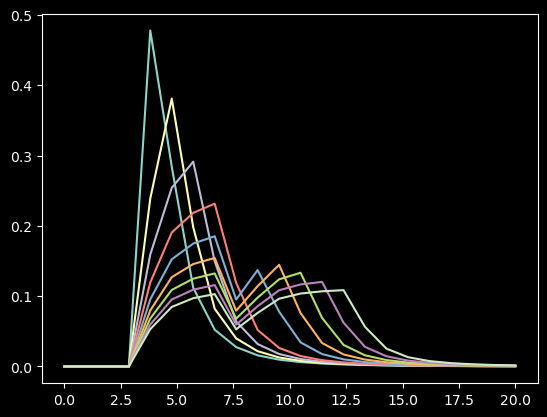

In [8]:
p_d = gl.get_infection_prob_dist_dict(infection_times_cluster_list=[0,1,2,3,5,6,7,8,9,10,11])
for i in range(1,10):
    plt.plot(np.linspace(0,20,22),p_d[i] , label=f'{i}')

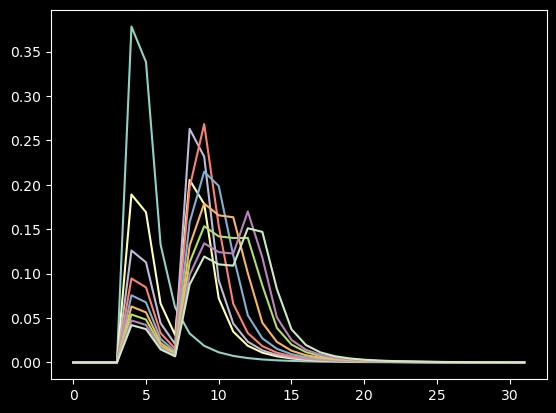

In [55]:
p_d = get_infection_prob_dist_dict(infection_times_cluster_list=mean_inf_times)
for i in range(1,10):
    plt.plot(np.arange(0,len(p_d[i]),1),p_d[i] , label=f'{i}')

In [54]:
p_d[i]
np.arange(0,len(p_d[i]),1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

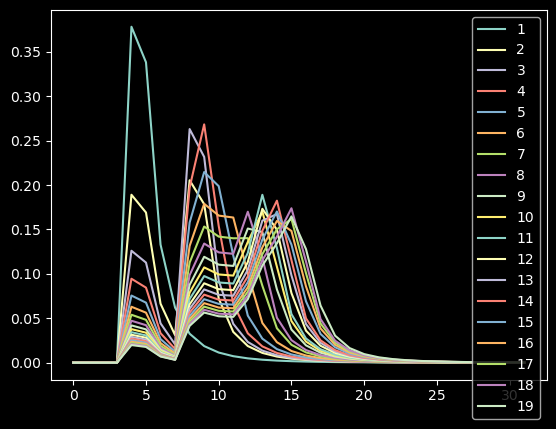

In [59]:
for i in range(1,20):
    plt.plot(np.arange(0,len(p_d[i]),1),p_d[i], label=f'{i}')
plt.legend()    
#agents_dict = {ID: Agent(ID, 0, size = w1.ai_df['cluster_size'][w1.ai_df['cluster']==ID].values[0]) for ID in w1.ai_df['cluster'].unique()}

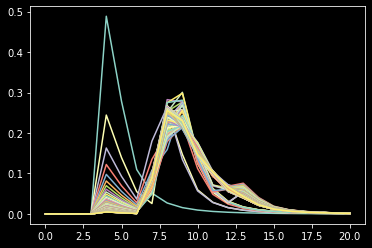

In [333]:
for size,ps in w1.infect_prob_dist_per_size.items():
    plt.plot(np.linspace(0,20,21),ps, label=f'{size}')
#plt.legend()    

In [61]:
np.array(0*[0.0]+list(p[:-(0+1)]))
len(p_1)
np.array(dt*[0.0]+list(p[:-(dt)]))
sum([p,p_1,p_2,p_3])

array([0.        , 0.        , 0.        , 0.        , 0.4885804 ,
       0.76701167, 1.36525742, 0.71781597, 0.29767807, 0.14518514,
       0.07919011, 0.04674592, 0.02926604, 0.01917832, 0.01303608,
       0.0091315 , 0.00655973, 0.00481462, 0.00359997, 0.00273577,
       0.00210899])

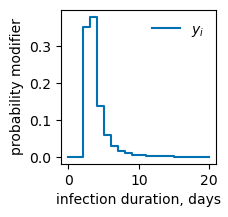

In [136]:
m, dt = 3,1
p = create_lognorm_probability_dist(s=0.91,a=m,days=20)
fig, ax =  plt.subplots(1,1, figsize=(2,2))
ax.step(np.linspace(0,20,21),p, label=r'$y_i$')
ax.legend(frameon=False)
ax.set_xlabel('infection duration, days')
ax.set_ylabel('probability modifier')
fig.savefig('plots/scheme_inf_prob.png', dpi=152, bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'output/plots/scheme_inf_prob.png'

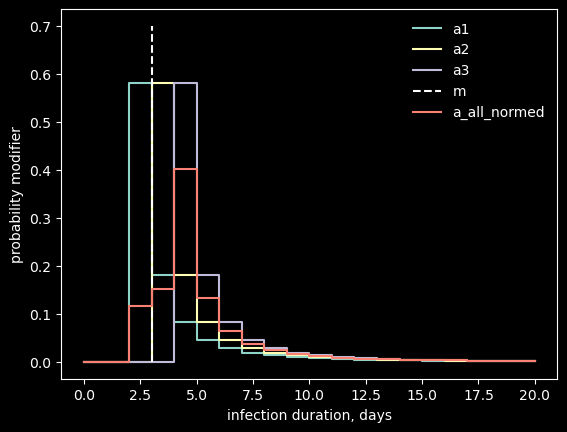

In [68]:
dt=1
m=3
p = create_lognorm_probability_dist(s=1.4,a=m,days=20)
plt.step(np.linspace(0,20,21),p, label='a1')
p_1 = np.array(dt*[0.0]+list(p[:-(dt)]))
p_2 = np.array((dt+1)*[0.0]+list(p[:-(dt+1)]))
p_3 = np.array((dt+1)*[0.0]+list(p[:-(dt+1)]))
p_4 = np.array((dt+1)*[0.0]+list(p[:-(dt+1)]))
p_n = (p+p_1+p_2+p_3+p_4)/5
plt.step(np.linspace(0,20,21),p_1, label='a2')
plt.step(np.linspace(0,20,21),p_2, label='a3')
plt.plot([m]*10, np.linspace(0,0.7,10), label='m', c='white',linestyle='--')
plt.step(np.linspace(0,20,21),sum([p,p_1,p_2,p_3,p_4])/5, label='a_all_normed')
plt.legend(frameon=False)
plt.xlabel('infection duration, days')
plt.ylabel('probability modifier')
plt.savefig('output/plots/scheme_inf_prob.png')


In [419]:
#x=np.random.lognormal(mean=1.1,sigma=0.4,size=100)
#x = x.astype(int)+2

#certainty= 0.9999,
certainty= 0.999
w1 = World(p_l_t_filepath = 'source/Gangelt_03_new_p_l_t.gz',
           ai_df_filename = 'source/Gangelt_03_new_ai_df.gz',
           infection_times_cluster_list=mean_inf_times, ## with mean times for cluster size up to  50 
           clustering=True, 
           certainty= certainty, 
           use_suggested_k=True,
           n_clusters= 200,
           k_I=0.2,### achtung! half kI!!!
           max_t=70, 
           indvid_clust_for_exclud_agent=True)
w2  = World(p_l_t_filepath = 'source/Gangelt_03_new_p_l_t.gz',
           ai_df_filename = 'source/Gangelt_03_new_ai_df.gz',
           infection_times_cluster_list=mean_inf_times, ## with mean times for cluster size up to  50 
           clustering=False)

INFO:root:max_t 70
INFO:root:certainty 0.999
INFO:root:number of agents: 1060
INFO:root:create contact list
INFO:root:contact list is done
INFO:root:Projection of P_ijt to PijT for 69 time steps is done
INFO:root:P is a singular matrix, removing rows and columns with only zeros
INFO:root:163 agents have no certain contact in this time frame
INFO:root:use suggested k:235 instead of 200
INFO:root:eigenvalues done
INFO:root:kmeans_done
INFO:root:create contact list
INFO:root:contact list is done
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 9
INFO:root:inner cluster interactions 24
INFO:root:inner cluster interactions 25
INFO:root:inner cluster interactions 30
INFO:root:inner cluster interactions 39
INFO:root:inner cluster interactions 39
INFO:root:inner cluster inter

In [420]:
model1 = SIS_model(copy.deepcopy(w1))
model2 = SIS_model(copy.deepcopy(w2))

In [78]:
model2.reset()

In [187]:
model1.world.infect_prob_dist_per_size.keys()#[agents[1].size]#[inf_duration_days]


dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [421]:
import time
times =[time.time()]
for model in [model1,model2]:
    #model.reset()
    model.world.agents[1].state=1 # infect one agent
    model.world.agents[1].times['infection']=0 
    model.run(timespan=2000, only_inf_rel_contacts=True)
    times.append(time.time()) 
    print(times[-1]-times[-2])
    # only_inf_rel_contacts=False 25min52.5s

/Users/bjoern/miniconda3/envs/gerdaenv/lib/python3.7/site-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6.483078956604004
6.69015908241272


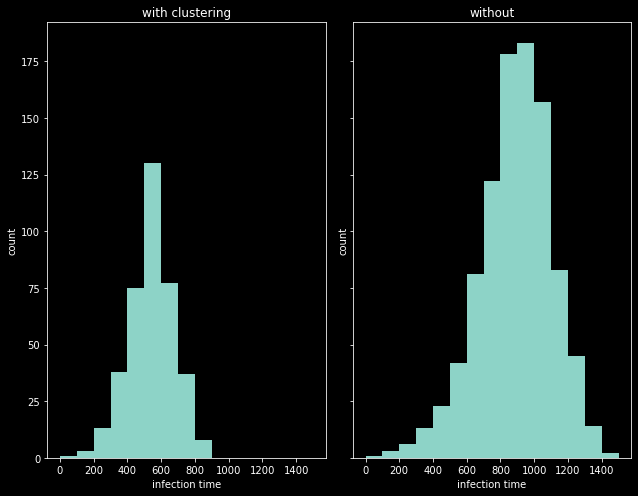

In [422]:
fig, axes = plt.subplots(1,2, figsize=(9,7), sharey='row')
colors = plt.cm.GnBu_r(np.linspace(0, 1, 21))  
pds = []
for i,model in enumerate([model1,model2]):
    #ax0,ax1 = axes[0][i],axes[1][i]
    ax0 = axes[i]
    ax0.set_title('scaled infectivity probability')
    ax1.set_title('without')

    plot_inf_times(model, ax0, bins=np.arange(0,1600,100))
    p_d = model.world.infect_prob_dist_per_size
    pds.append(p_d)
    for k in range(1,21):
        ax1.plot(np.arange(0,p_d[k].shape[0],1),p_d[k], label=f'{k}', color=colors[k],alpha=0.9)
        
        ax1.set_xlim(0,30)
        ax1.set_xlabel('time, days')
        ax1.set_ylabel('infection probability')
ax1.legend(title='cluster size', frameon=False,ncol=3)
axes[0].set_title('with clustering')
axes[1].set_title('without')     
plt.tight_layout()
#fig.savefig('output/plots/clustered_scaled_inf_1_20.png', bbox_inches='tight')

<AxesSubplot:>

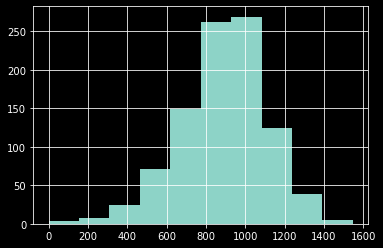

In [427]:
wo_c_model = model2
wo_c_model.world.ai_df
inf_times_dict = {}
for agent_ID,agent in wo_c_model.world.agents.items():
    inf_times_dict[agent_ID] = agent.times['infection']
wo_c_model.world.ai_df['infection_time'] = wo_c_model.world.ai_df['h_ID'].map(inf_times_dict)
wo_c_model.world.ai_df['infection_time'].hist()

In [36]:
times[1]-times[0]
times[2]-times[1]

6.930754899978638

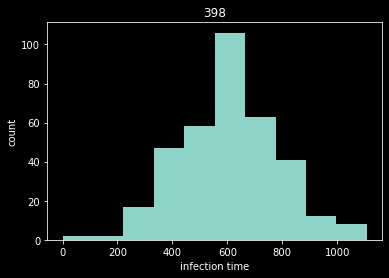

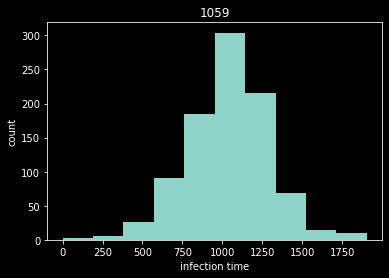

In [38]:
for m in [model1,model2]:
    l1=[]
    l2 = []
    for id, a in m.world.agents.items():
        l1.append(a.times['infection'])
        l2.append(a.state)
    plt.figure()
    plt.title(f'{len(m.world.agents)}')
    np.histogram(np.array([x for x in l1 if x is not None]))
    plt.hist(np.array([x for x in l1 if x is not None]))
    plt.xlabel('infection time')
    plt.ylabel('count')

(Text(0.5, 0, 'time'), Text(0, 0.5, 'Infected'))

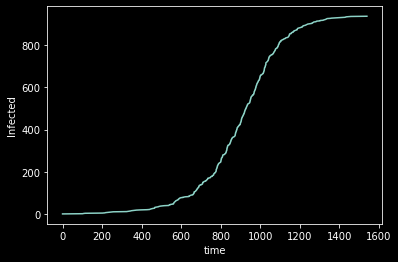

In [280]:
import pandas as pd

df = pd.DataFrame({'inf_time': l1, 'state':l2})
df_sort = df.sort_values('inf_time')
np.cumsum(df_sort['state'])
plt.plot(df_sort['inf_time'], np.cumsum(df_sort['state']))
plt.xlabel('time'), plt.ylabel('Infected')

INFO:root:max_t 168
INFO:root:certainty 0.999
INFO:root:number of agents: 1060
INFO:root:create contact list
INFO:root:contact list is done
INFO:root:Projection of P_ijt to PijT for 167 time steps is done
INFO:root:P is a singular matrix, removing rows and columns with only zeros
INFO:root:124 agents have no certain contact in this time frame
INFO:root:use suggested k:157 instead of 250


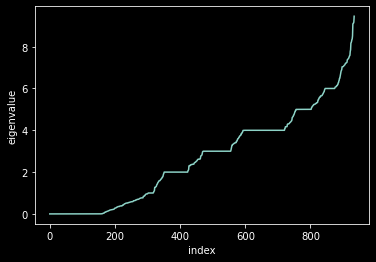

INFO:root:create contact list
INFO:root:contact list is done
INFO:root:inner cluster interactions 27
INFO:root:inner cluster interactions 27
INFO:root:inner cluster interactions 27
INFO:root:inner cluster interactions 27
INFO:root:inner cluster interactions 27
INFO:root:inner cluster interactions 27
INFO:root:inner cluster interactions 54
INFO:root:inner cluster interactions 231
INFO:root:inner cluster interactions 252
INFO:root:inner cluster interactions 301
INFO:root:inner cluster interactions 379
INFO:root:inner cluster interactions 372
INFO:root:inner cluster interactions 301
INFO:root:inner cluster interactions 314
INFO:root:inner cluster interactions 328
INFO:root:inner cluster interactions 267
INFO:root:inner cluster interactions 202
INFO:root:inner cluster interactions 163
INFO:root:inner cluster interactions 77
INFO:root:inner cluster interactions 27
INFO:root:inner cluster interactions 27
INFO:root:inner cluster interactions 27
INFO:root:inner cluster interactions 27
INFO:roo

 time :4.999050140380859


Text(0, 0.5, 'count')

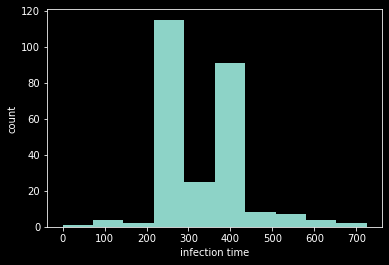

In [71]:

w1 = World(clustering=True,
            p_l_t_filepath= 'source/Gangelt_03_new_p_l_t.gz',
            ai_df_filename='source/Gangelt_03_new_ai_df.gz',
            k_I=0.1)
model = SIS_model(w1)
model.world.agents[1].state = 1 # infect one agent
model.world.agents[1].times['infection'] = 0 
t1 = time.time()
model.run(timespan=1500) 
t2 = time.time()

print(f' time :{t2-t1}')

l1=[]
l2 = []
for id, a in model.world.agents.items():
    l1.append(a.times['infection'])
    l2.append(a.state)

np.histogram(np.array([x for x in l1 if x is not None]))
plt.hist(np.array([x for x in l1 if x is not None]))
plt.xlabel('infection time')
plt.ylabel('count')


In [48]:
#sum([len(x) for x in model.real_contacts])
#len(model.real_contacts)
#model.real_contacts

def get_contacts_per_cluster_pair(contact_list)->dict:
    pair_dict = {}
    for pair in contact_list:
        ts = tuple(set(pair))
        if ts in pair_dict:
            pair_dict[ts] += 1
        else:
            pair_dict[ts] = 1
    return pair_dict        

t=1
d = get_contacts_per_cluster_pair(model.real_contacts[t])

#633761
#1306822
#model.real_contacts

In [474]:
[1 for x in model.real_contacts if x[0]==x[1]]
len(set(model.real_contacts)) /  len(model.real_contacts)

0.032491630058861874

3


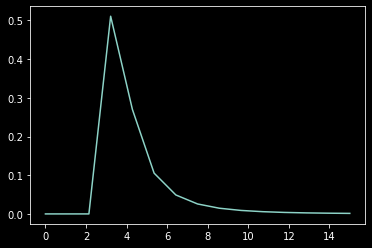

In [151]:
r = create_lognorm_probability_dist(s=1,a=3,days=14)
r.sum()
print(np.argmax(r))
x = np.linspace(0,len(r),len(r))
plt.plot(x,r)

#### Impact of the Infection Times insinde the clusters on the Dynamics

In [280]:
mean_inf_times
#[0.0]+np.ones(50)

array([ 0,  4,  4,  5,  6,  7,  8,  8,  8,  9,  9, 10, 10, 10, 10, 10, 11,
       11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15,
       15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 19, 20, 20, 21])

In [409]:
w1 = World(p_l_t_filepath = 'source/Gangelt_03_new_p_l_t.gz',
           ai_df_filename = 'source/Gangelt_03_new_ai_df.gz',
           infection_times_cluster_list=mean_inf_times, ## with mean times for cluster size up to  50 
           clustering=True, 
           certainty= certainty, 
           use_suggested_k=True,
           n_clusters= 200,
           k_I=0.2,
           max_t=70, 
           indvid_clust_for_exclud_agent=True)
w2 = World(p_l_t_filepath = 'source/Gangelt_03_new_p_l_t.gz',
           ai_df_filename = 'source/Gangelt_03_new_ai_df.gz',
           infection_times_cluster_list=[0]+list(np.ones(50)), ## with mean times for cluster size up to  50 
           clustering=True, 
           certainty= certainty, 
           use_suggested_k=True,
           n_clusters= 200,
           k_I=0.2,
           max_t=70, 
           indvid_clust_for_exclud_agent=True)

INFO:root:max_t 70
INFO:root:certainty 0.999
INFO:root:number of agents: 1060
INFO:root:create contact list
INFO:root:contact list is done
INFO:root:Projection of P_ijt to PijT for 69 time steps is done
INFO:root:P is a singular matrix, removing rows and columns with only zeros
INFO:root:163 agents have no certain contact in this time frame
INFO:root:use suggested k:235 instead of 200
INFO:root:eigenvalues done
INFO:root:kmeans_done
INFO:root:create contact list
INFO:root:contact list is done
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 6
INFO:root:inner cluster interactions 9
INFO:root:inner cluster interactions 24
INFO:root:inner cluster interactions 25
INFO:root:inner cluster interactions 30
INFO:root:inner cluster interactions 39
INFO:root:inner cluster interactions 39
INFO:root:inner cluster inter

In [410]:
model1 = SIS_model(copy.deepcopy(w1))
model2 = SIS_model(copy.deepcopy(w2))

In [411]:
for model in [model1,model2]:
    #model.reset()
    model.world.agents[1].state=1 # infect one agent
    model.world.agents[1].times['infection']=0 
    model.run(timespan=2000, only_inf_rel_contacts=True)


/Users/bjoern/miniconda3/envs/gerdaenv/lib/python3.7/site-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


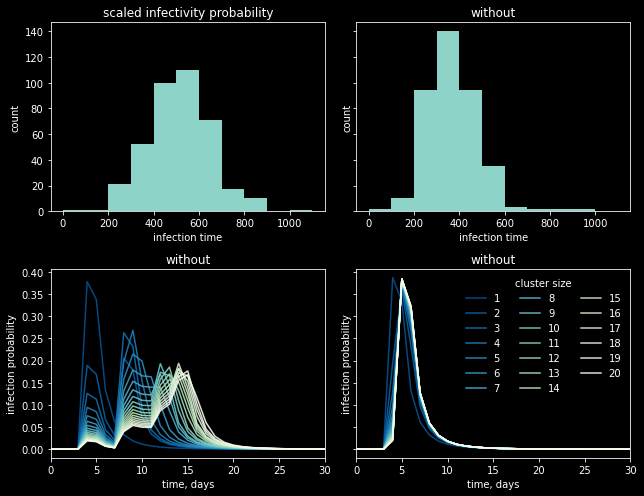

In [412]:
fig, axes = plt.subplots(2,2, figsize=(9,7), sharey='row')
colors = plt.cm.GnBu_r(np.linspace(0, 1, 21))  
pds = []
for i,model in enumerate([model1,model2]):
    ax0,ax1 = axes[0][i],axes[1][i]
    ax0.set_title('scaled infectivity probability')
    ax1.set_title('without')

    plot_inf_times(model, ax0, bins=np.arange(0,1200,100))
    p_d = model.world.infect_prob_dist_per_size
    pds.append(p_d)
    for k in range(1,21):
        ax1.plot(np.arange(0,p_d[k].shape[0],1),p_d[k], label=f'{k}', color=colors[k],alpha=0.9)
        
        ax1.set_xlim(0,30)
        ax1.set_xlabel('time, days')
        ax1.set_ylabel('infection probability')
ax1.legend(title='cluster size', frameon=False,ncol=3)
axes[0][0].set_title('scaled infectivity probability')
axes[0][1].set_title('without')     
plt.tight_layout()
fig.savefig('output/plots/clustered_scaled_inf_1_20.png', bbox_inches='tight')



<AxesSubplot:title={'center':'infection_time'}>

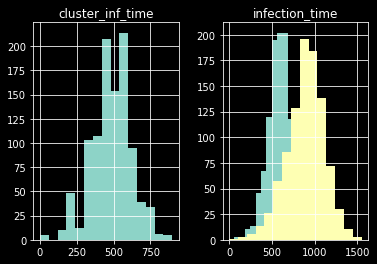

In [429]:
## assign infection times to the agents in the clusters, considering the mean infection timing used for the simulations
### add infection timing 
##get agent information Dataframe
df = model1.world.ai_df
mean_inf_times 

## get cluster infection times and map them on the agents 
cluster_inf_times_dict ={}
for agent_ID,agent in model1.world.agents.items():
    cluster_inf_times_dict[agent_ID] = agent.times['infection']
df['cluster_inf_time'] = df['cluster'].map(cluster_inf_times_dict)


## infection timings refer to the timing of the infection in the cluster
def assign_inf_timing(cluster, inf_timings):
    #c_ID = cluster['cluster']#.iloc[0]#.values()[0]
    #print(int(c_ID.iloc[0]))
    cluster['Infection_timing'] = np.array(inf_timings[:len(cluster)])*24#+cluster_inf_times_dict[int(c_ID.iloc[0])]
    return cluster


df = df.groupby('cluster').apply(assign_inf_timing, inf_timings=mean_inf_times).reset_index(drop=True)

df['infection_time'] = df['cluster_inf_time']+df['Infection_timing']
df[['cluster_inf_time','infection_time']].hist(bins=15)
wo_c_model.world.ai_df['infection_time'].hist(bins=15)

In [361]:
l3 = copy.copy(mean_inf_times)
list(np.array(l3)*2)
mean_inf_times


array([ 0,  4,  4,  5,  6,  7,  8,  8,  8,  9,  9, 10, 10, 10, 10, 10, 11,
       11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15,
       15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 19, 20, 20, 21])

In [309]:
import pandas as pd

# Create a sample DataFrame
data = {
    'Group': ['A', 'A', 'B', 'B', 'C', 'C'],
}
df = pd.DataFrame(data)

# Define the list of values
values = ['X', 'Y', 'Z', 'P', 'Q', 'R']

# Define a function to assign values within each group
def assign_value(group):
    group['Value'] = values[:len(group)]
    return group

# Apply the function to each group using groupby and apply
df = df.groupby('Group').apply(assign_value).reset_index(drop=True)

print(df)

  Group Value
0     A     X
1     A     Y
2     B     X
3     B     Y
4     C     X
5     C     Y


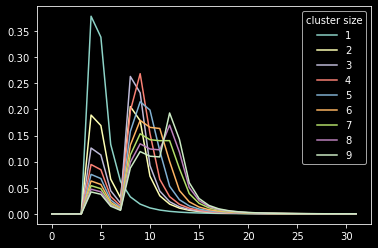

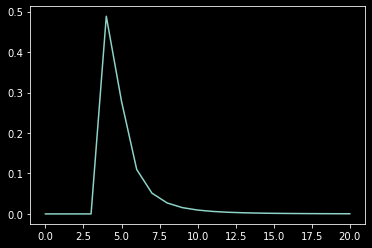

In [183]:
p_d =model1.world.infect_prob_dist_per_size
for i in range(1,10):
    plt.plot(np.arange(0, p_d[i].shape[0],1), p_d[i], label=f'{i}')
plt.legend(title='cluster size')

plt.figure()
days = 20 
p = create_lognorm_probability_dist(s=1,a=4,days=days)
plt.plot(np.arange(0, days+1,1), p )



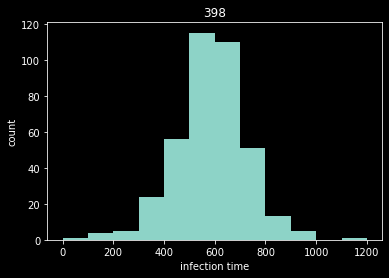

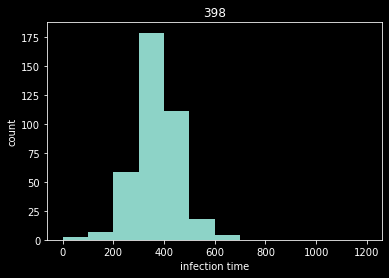

In [98]:
for m in [model1,model2]:
    l1=[]
    l2 = []
    for id, a in m.world.agents.items():
        l1.append(a.times['infection'])
        l2.append(a.state)
    plt.figure()
    plt.title(f'{len(m.world.agents)}')
    #np.histogram(np.array([x for x in l1 if x is not None]))
    plt.hist(np.array([x for x in l1 if x is not None]), bins=np.arange(0,1300,100))
    plt.xlabel('infection time')
    plt.ylabel('count')

In [277]:
def plot_inf_times(model,ax=None, **h_kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    l1=[]
    for id, a in model.world.agents.items():
        l1.append(a.times['infection'])
    ax.set_title(f'{len(model.world.agents)}')
    #np.histogram(np.array([x for x in l1 if x is not None]))
    ax.hist(np.array([x for x in l1 if x is not None]), **h_kwargs)
    ax.set_xlabel('infection time')
    ax.set_ylabel('count')